1. Import libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import make_scorer
plt.rcParams["figure.figsize"] = (7, 7)

2. Define functions to load data, create features

In [47]:
def csv_loader(path, index_col=True, flip=True):
    if index_col:
        df = pd.read_csv(path, index_col=0, parse_dates=True) 
    else: df = pd.read_csv(path)
    if flip:
        df = df.iloc[::-1]
    return df

def create_features(df):
    df['Spread'] = df['High'] - df['Low']
    df['LastClose'] = df['Close'].shift(periods=1)
    df['Gap'] = df['Open'] - df['LastClose']
    return df

def drop_features(df):
    df.drop(columns=['Spread',
                     'LastClose',
                     'Gap',
                     ],
            inplace=True)
    
    df.drop(columns=['Open','High','Low','Close','Volume',
                     #'Adj Close'
                     ], inplace=True)
    return df

def process_features(df, lookback, step):
    lookback += 1
    for i in range(step, lookback, step):
        df['%d Max' % (i)] = df['High'].rolling(window=i).max()
        df['%d Max' % (i)] = df['%d Max' % (i)].pct_change(fill_method=None)
        df['%d Min' % (i)] = df['Low'].rolling(window=i).min()
        df['%d Min' % (i)] = df['%d Min' % (i)].pct_change(fill_method=None)

        df['%d Spread' % (i)] = df['Spread'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Spread' % (i)] = df['Spread'].rolling(window=i).mean()

        df['%d Gap' % (i)] = df['Gap'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Gap' % (i)] = df['Gap'].rolling(window=i).mean()

        df['%d Rolling Avg Open' % (i)] = df['Open'].rolling(window=i).mean()
        df['%d Rolling Avg Open' % (i)] = df['%d Rolling Avg Open' % (i)].pct_change(fill_method=None)

        df['%d Rolling Avg High' % (i)] = df['High'].rolling(window=i).mean()
        df['%d Rolling Avg High' % (i)] = df['%d Rolling Avg High' % (i)].pct_change(fill_method=None)

        df['%d Rolling Avg Low' % (i)] = df['Low'].rolling(window=i).mean()
        df['%d Rolling Avg Low' % (i)] = df['%d Rolling Avg Low' % (i)].pct_change(fill_method=None)

        df['%d Rolling Avg Close' % (i)] = df['Close'].rolling(window=i).mean()
        df['%d Rolling Avg Close' % (i)] = df['%d Rolling Avg Close' % (i)].pct_change(fill_method=None)
    return df
  
def features(df, lookback, step):
    create_features(df)
    process_features(df, lookback, step)
    drop_features(df)
    return df

3. Create a function to create a target.

In [48]:
def create_target(df, lookforward=2, target='Open'):
    df['Target'] = np.log(df[target].shift(periods=-lookforward)/df[target].shift(periods=-1))
    return df

4. Create a custom scoring function.

In [49]:
def custom_score(y_true, y_pred):
  pred_sign = np.sign(y_pred)
  y_true = np.squeeze(y_true)
  returns = np.where((pred_sign == 1), y_true, 0)
  return returns.mean()

custom_scorer = make_scorer(custom_score, greater_is_better=True)

With this scoring function, we are scoring differnet models on their average returns, as opposed to the normal scoring function of a regression model, which would be R^2 or RMSE, both of which are fine if we were predicting price, but accurately predicting price =/= good returns. So instead we just score the models directly on their average returns.

5. Define the models we are going to use


In [50]:
estimator1 = Ridge()
estimator2 = Lasso(alpha=.001)
#estimator3 = ElasticNet(alpha=.001)
estimator4 = KNeighborsRegressor()
models = [estimator1,
          estimator2,
          #estimator3,
          estimator4
          ]
estimator = VotingRegressor(estimators=[('Ridge', estimator1),
                                        ('Lasso', estimator2),
                                        #('ENet'), estimator3),
                                        ('KNN', estimator4),
                                        ],)

You will notice that we have commented out the ElasticNet model, this is because its output was the same as the output from the Lasso model, which won't add any good performance to our model, and will use up more compute resources. Though this might not be the case if we were to adjust the alpha parameter, but for now we will keep it commented out. If you want to include it, uncomment it, or remove the hashtags.

Next, we combine the 3 models into 1 using the VotingRegressor. The VotingRegressor works by averaging the output of the models that its composed of into a single output. Go to this link for more info: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html

6. Define target, cross validation folds, interval, and lookback parameters.

In [51]:
lookforward = 2
tscv = TimeSeriesSplit(n_splits=4, gap=lookforward)
steps = [1, 2, 3, 4, 5]
lookbacks = [1, 2, 3, 4, 5]
cv_results = pd.DataFrame(columns=['step', 'lookback', 'score'])

To make sure the strategy our models come up with are actually significant, and not just a memorization of the data we gave it, we test the model 4 times (n_splits=4). We also have to add a gap between each split, otherwise there will be some overlap, which could cause the models to peek at data it shouldn't, and artificially inflate its score. Next we define the steps (or intervals) and lookbacks we want to test our model at, in order to find the ones that it scores the highest on. Lastly, we create an object to store the results of our model in. 

7. Evaluate and visualize scores of different combinations of parameters

In [ ]:
for step in steps:
    for lookback in lookbacks:
        if lookback >= step:
            spy = csv_loader(path='/content/SPY.csv', index_col=True, flip=False)
            agg = csv_loader(path='/content/AGG.csv', index_col=True, flip=False)

            spy = create_target(spy, lookforward, target='Open')

            spy = features(spy, lookback, step)
            spy = spy.add_suffix(' SPY')
            agg = features(agg, lookback, step)
            agg = agg.add_suffix(' AGG')
            cv = pd.merge(spy, agg, how='inner', on='Date')

            cv.drop(cv.tail(lookforward).index, inplace=True)
            cv.drop(cv.head(max(lookbacks)).index, inplace=True)
            X = cv
            y = X[['Target SPY']]
            X = X.drop(columns=['Target SPY'])
            X.fillna(method="ffill", inplace=True)
            X.replace([np.inf, -np.inf], 0, inplace=True)
            X.fillna(0, inplace=True)

            cv_score = cross_val_score(estimator=estimator, X=X, y=y,
                                       scoring=custom_scorer,
                                       cv=tscv, verbose=0)

            cv_results = cv_results.append({'step': step, 'lookback': lookback, 'score': cv_score.mean()}, ignore_index=True)


In the previous notebook, I didnt explain the inputs of our model, as it wasn't necessary, but here it is. The inputs of our model is going to the S&P500 ETF, SPY, and a bond ETF, AGG. The reason for this is because the S&P500 is the most liquid ETF, so [slippage](https://www.investopedia.com/terms/s/slippage.asp) won't be too high of a penalizing factor. And the reason for using bonds as an additional input is because bonds aren't always correlated with the overall market, giving our model an additional perspective on the market as opposed to just using SPY. 

8. Visualize results in a heatmap

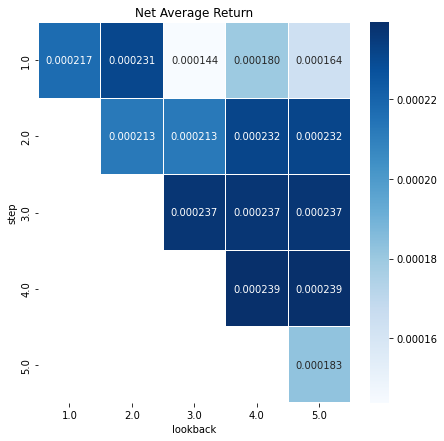

In [55]:
cv_results = cv_results.pivot(index='step', columns='lookback', values='score')
sns.heatmap(cv_results, annot=True, fmt='.6f', linewidths=.25, cmap='Blues')
plt.title('Net Average Return')
plt.show()

Here we can see a 4 period step interval with a maximum look back of 4 periods performs the best. In the next notebook, we will adjust the parameters of the models 

BONUS: Back test best parameters

In [ ]:
!pip3 install backtesting
from backtesting import Strategy, Backtest
from sklearn.model_selection import train_test_split

In [58]:
step = 4
lookback = 4

spy = csv_loader(path='/content/SPY.csv', index_col=True, flip=False)
agg = csv_loader(path='/content/AGG.csv', index_col=True, flip=False)

spy = create_target(spy, lookforward, target='Open')

spy = features(spy, lookback, step)
spy = spy.add_suffix(' SPY')
agg = features(agg, lookback, step)
agg = agg.add_suffix(' AGG')
cv = pd.merge(spy, agg, how='inner', on='Date')

cv.drop(cv.tail(lookforward).index, inplace=True)
cv.drop(cv.head(max(lookbacks)).index, inplace=True)
X = cv
y = X[['Target SPY']]
X = X.drop(columns=['Target SPY'])
X.fillna(method="ffill", inplace=True)
X.replace([np.inf, -np.inf], 0, inplace=True)
X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
X_test = X_test.iloc[(abs(lookforward)):]
y_test = y_test.iloc[(abs(lookforward)):]

estimator.fit(X_train, y_train)
forecasted = estimator.predict(X_test)

data = csv_loader(path='/content/SPY.csv', index_col=True, flip=False)
data.drop(data.tail(lookforward).index,inplace=True)
data.drop(data.head(lookback).index,inplace=True)
data = data.iloc[(-X_test.shape[0]):]
data['forecastedValue'] = forecasted
prediction = data

class MyStrategy(Strategy):
    Data = prediction

    def init(self):
        super().init()

    def next(self):
        if self.data.forecastedValue < 0:
            self.sell()
        elif self.data.forecastedValue > 0:
            self.buy()


bt = Backtest(prediction, MyStrategy,
              cash=1000,
              trade_on_close=False,
              exclusive_orders=True
              )
print(bt.run())
bt.plot()

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Start                     2018-12-04 00:00:00
End                       2022-09-16 00:00:00
Duration                   1382 days 00:00:00
Exposure Time [%]                   99.790136
Equity Final [$]                   943.399236
Equity Peak [$]                   1154.729475
Return [%]                          -5.660076
Buy & Hold Return [%]               42.667899
Return (Ann.) [%]                   -1.528901
Volatility (Ann.) [%]               19.186373
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -31.037578
Avg. Drawdown [%]                   -5.223944
Max. Drawdown Duration     1073 days 00:00:00
Avg. Drawdown Duration      137 days 00:00:00
# Trades                                  951
Win Rate [%]                        45.636172
Best Trade [%]                       6.348897
Worst Trade [%]                     -8.799434
Avg. Trade [%]                    

Row(id='12885', ...)

Before we evaluate the results, one thing to mention is that the result from this back test is cheating a little bit, since we evaluated this data when we used TimeSeriesSplit. In order to make sure what we have is a real strategy, we need to remove the amount we are going to back test first, lets say 20%, and then cross validate using TimeSeriesSplit with the rest 80%, this way, our model has no way to cheat since it hasn't seen the last 20%.

Onto the results, they don't seem to be anything special, but thats fine, we will test it again after we optimize the parameters on the models and see how well it performs then.